In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from libs.pconv_model import PConvUnet
from libs.util import ImageChunker, MaskGenerator
import matplotlib.image as mpimg
import cv2
from matplotlib import cm
from mpl_toolkits import mplot3d
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
%load_ext tensorboard

def plot_pred(_pred, _mask, _orig):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(_orig * _mask)
    axes[1].imshow(_pred)
    axes[2].imshow(_orig)
    axes[0].set_title('Masked Image')
    axes[1].set_title('Predicted Image')
    axes[2].set_title('Original Image')


def heatmap2d(x, y, z, _orig=None):
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    if _orig is None:
        fig, ax = plt.subplots()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('')
        ax.axis([x.min(), x.max(), y.min(), y.max()])
        fig.colorbar(c, ax=ax)
        plt.show()
    else:
        _, axes = plt.subplots(1, 2, figsize=(20, 8))
        axes[0].imshow(_orig)
        axes[0].set_title('Original Image')
        c = axes[1].pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        axes[1].set_title('Diff. map')
        axes[1].axis([x.min(), x.max(), y.min(), y.max()])
        _.colorbar(c, ax=axes[1])
        plt.show()


def diff_plot(_pred, _orig, quiet=False):
    
    # Look at the differences in each channel then average them
    for n in range(3):
        ch_pred = _pred[:,:,n]
        ch_orig = _orig[:,:,n]
        if n==0:
            ch_diff = ch_pred-ch_orig
        else:
            ch_diff += ch_pred-ch_orig
    ch_diff = ch_diff/3
    
    X2, Y2 = np.meshgrid(range(_pred.shape[0]), range(_pred.shape[1]))
    
    # Normalize the colors based on Z value
    norm = plt.Normalize(ch_diff.min(), ch_diff.max())
    colors = cm.jet(norm(ch_diff))
    
    if not quiet:
        ax = plt.axes(projection='3d')
        surf = ax.plot_surface(X2, Y2, ch_diff, facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
    return X2, Y2, ch_diff

# Function to overwrite original image with pixels from prediction
def apply_mask(_mask, _pred, _orig):
    masked = _orig * _mask
    shape = masked.shape
    for x in range(shape[0]):
        for y in range(shape[1]):
            if masked[x, y].all() < 0.01:
                masked[x, y] = _pred[x, y]
    return masked

The tensorboard module is not an IPython extension.


Using TensorFlow backend.


In [2]:
# SETTINGS
#SAMPLE_IMAGE = 'images/2_55.png'
SAMPLE_IMAGE = 'images/PGBM-014_04-02-1997-MR_RCBV_SEQUENCE-89894_9_True.png'

replacement_color_w = (1, 1, 1)
replacement_color_b = (0, 0, 0)

yset = range(30, 200)
xset = range(70, 180)

ori = cv2.imread(SAMPLE_IMAGE)
#ori = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)
#ori = mpimg.imread(SAMPLE_IMAGE)
#ori = ori[:,:,1:]

(width, height, depth) = ori.shape

i_mask = np.zeros((width, height, 3), dtype=np.uint8)

for x in range(width):
    for y in range(height):
        if x in xset and y in yset:
            i_mask[x, y] = replacement_color_b
        else:
            i_mask[x, y] = replacement_color_w

In [3]:
model = PConvUnet(vgg_weights="/DATA/sb/pytorch_to_keras_vgg16.h5", inference_only=True)
model.load("models/tp_weights.26-0.91.h5", train_bn=False)

In [4]:
chunker = ImageChunker(512, 512, 0)

ori = ori / 255.

chunked_images = chunker.dimension_preprocess(deepcopy(ori))
chunked_masks = chunker.dimension_preprocess(deepcopy(i_mask))
pred_imgs = model.predict([chunked_images, chunked_masks])
reconstructed_image = chunker.dimension_postprocess(pred_imgs, ori)

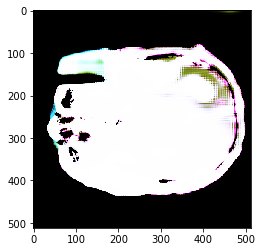

In [5]:
plt.imshow(reconstructed_image)

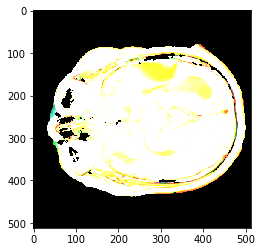

In [6]:
plt.imshow((ori))

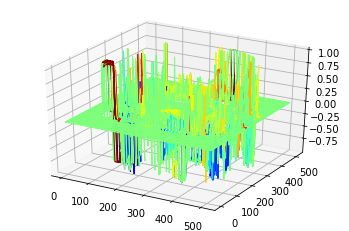

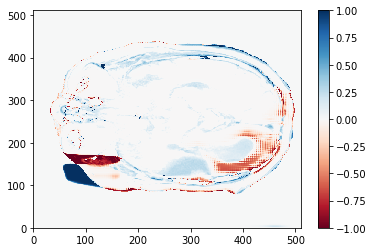

In [7]:
_x, _y, chd = diff_plot(reconstructed_image, ori)
heatmap2d(_x, _y, chd)

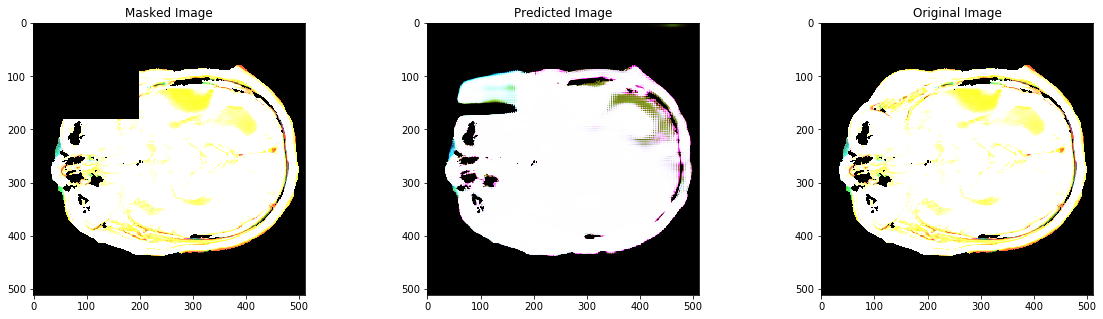

In [8]:
plot_pred(reconstructed_image, i_mask, ori)

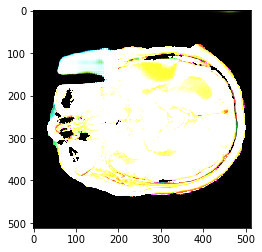

In [9]:
plt.imshow(apply_mask(i_mask, reconstructed_image, ori))

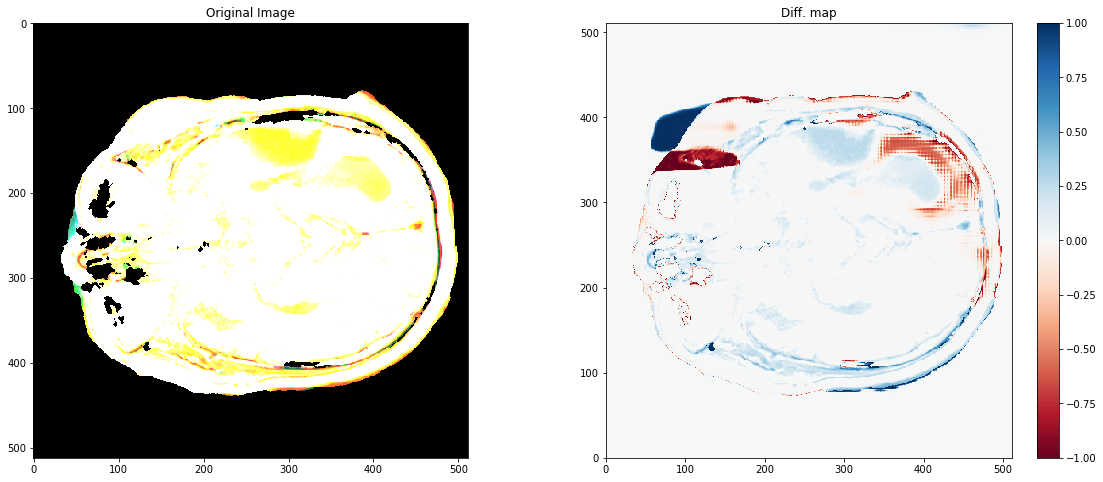

In [10]:
chd_flipped = np.flip(chd, axis=0)
heatmap2d(_x, _y, chd_flipped, _orig=ori)

In [11]:
### Multiple masks and applications
mask_gen = MaskGenerator(512, 512, rand_seed=42)

In [12]:
for n in range(50):
    if n==0:
        ori_im = ori
    
    mask_n = mask_gen._generate_mask()

    prepro_img = chunker.dimension_preprocess(deepcopy(ori_im))
    prepro_mask = chunker.dimension_preprocess(deepcopy(mask_n))
    pred_n = model.predict([prepro_img, prepro_mask])
    image_n = chunker.dimension_postprocess(pred_n, ori_im)
    ori_im = apply_mask(mask_n, image_n, ori_im)

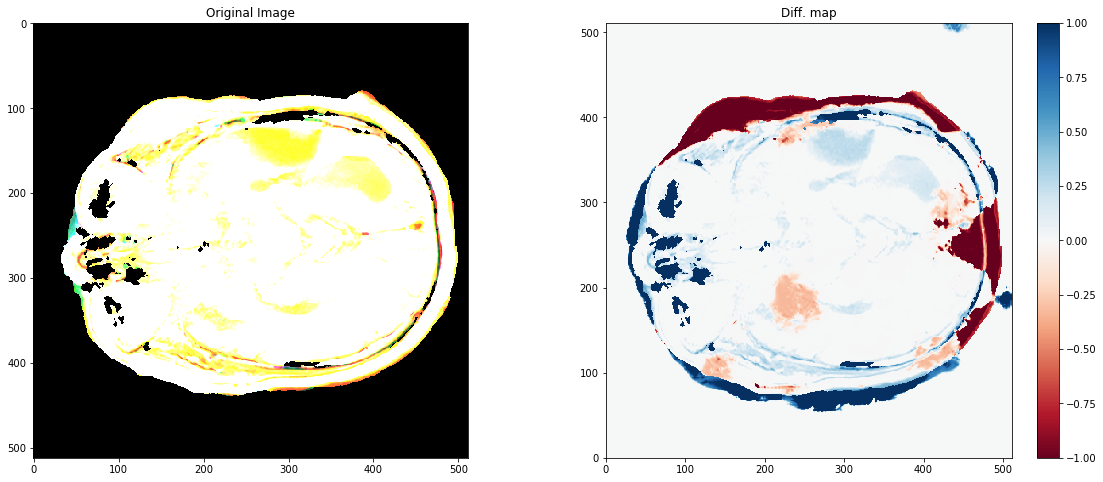

In [13]:
_x, _y, chd = diff_plot(ori_im, ori, quiet=True)

chd_flipped = np.flip(chd, axis=0)
heatmap2d(_x, _y, chd_flipped, _orig=ori)

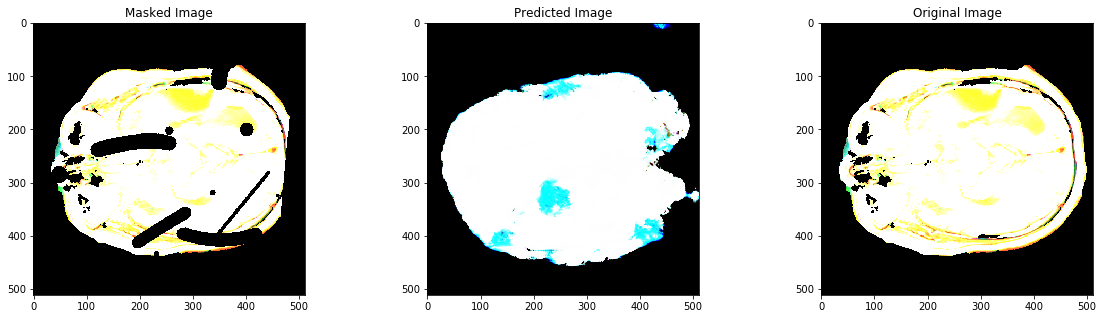

In [14]:
plot_pred(ori_im, mask_n, ori)

In [15]:
def RegularMaskGenerator(_width, _height, _xmin, _ymin, _sizex, _sizey):
    _xset = range(_xmin, _xmin+_sizex)
    _yset = range(_ymin, _ymin+_sizey)

    _i_mask = np.zeros((_width, _height, 3), dtype=np.uint8)

    for x in range(_width):
        for y in range(_height):
            if x in _xset and y in _yset:
                _i_mask[x, y] = replacement_color_b
            else:
                _i_mask[x, y] = replacement_color_w
                
    return _i_mask

In [16]:
sizex=60
sizey=60
for nx in range(int(512/sizex)+2):
    for ny in range(int(512/sizey)+2):
        if nx==0 and ny==0:
            ori_im = ori

        mask_n = RegularMaskGenerator(512, 512, nx*sizex, ny*sizey, sizex, sizey)

        prepro_img = chunker.dimension_preprocess(deepcopy(ori_im))
        prepro_mask = chunker.dimension_preprocess(deepcopy(mask_n))
        pred_n = model.predict([prepro_img, prepro_mask])
        image_n = chunker.dimension_postprocess(pred_n, ori_im)
        ori_im = apply_mask(mask_n, image_n, ori_im)

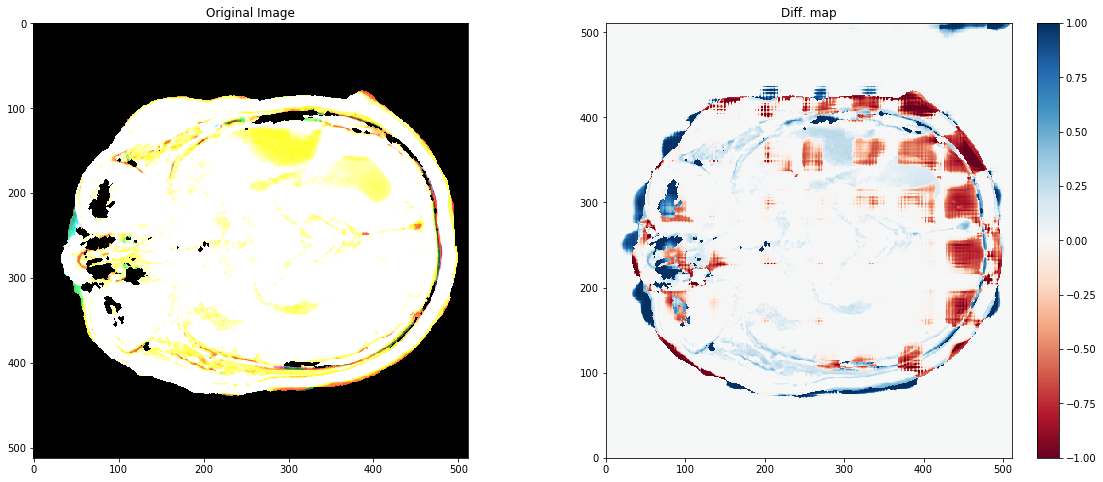

In [17]:
_x, _y, chd = diff_plot(ori_im, ori, quiet=True)

chd_flipped = np.flip(chd, axis=0)
heatmap2d(_x, _y, chd_flipped, _orig=ori)

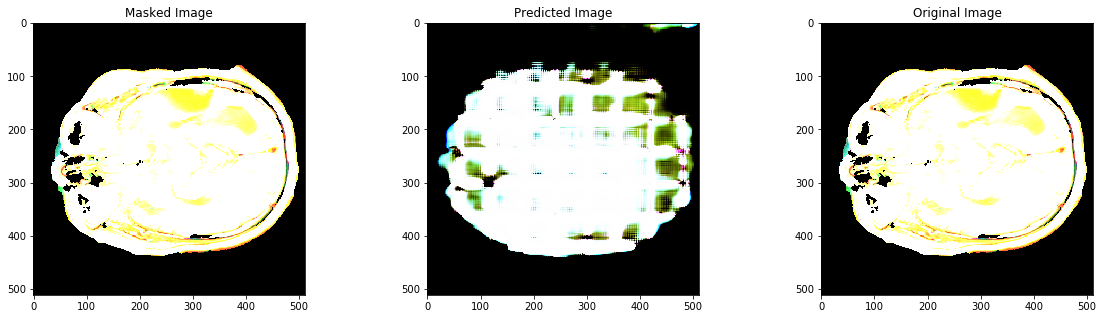

In [18]:
plot_pred(ori_im, mask_n, ori)